# Computer Vision Project - Classification of Flowers


In [1]:
# Read in label file and return a dictionary {'filename' : label}.
#
def import_labels(label_file):
    labels = dict()

    import csv
    with open(label_file) as fd:
        csvreader = csv.DictReader(fd)

        for row in csvreader:
            labels[row['filename']] = int(row['label'])
    return labels

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_root_dir, labels_dict, batch_size, target_dim, preprocess_func=None, use_augmentation=False):
        self._labels_dict = labels_dict
        self._img_root_dir = img_root_dir
        self._batch_size = batch_size
        self._target_dim = target_dim
        self._preprocess_func = preprocess_func
        self._n_classes = len(set(self._labels_dict.values()))
        self._fnames_all = list(self._labels_dict.keys())
        self._use_augmentation = use_augmentation

        if self._use_augmentation:
            self._augmentor = ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self._fnames_all)) / self._batch_size)

    def on_epoch_end(self):
        self._indices = np.arange(len(self._fnames_all))
        np.random.shuffle(self._indices)

    def __getitem__(self, index):
        indices = self._indices[index * self._batch_size:(index+1)*self._batch_size]

        fnames = [self._fnames_all[k] for k in indices]
        X,Y = self.__load_files__(fnames)

        return X,Y

    def __load_files__(self, batch_filenames):
        X = np.empty((self._batch_size, *self._target_dim, 3))
        Y = np.empty((self._batch_size), dtype=int)

        for idx, fname in enumerate(batch_filenames):
            img_path = os.path.join(self._img_root_dir, fname)
            img = image.load_img(img_path, target_size=self._target_dim)
            x = image.img_to_array(img)
           
            if self._preprocess_func is not None:
                x = self._preprocess_func(x)

            X[idx,:] = x 
            Y[idx] = self._labels_dict[fname]-1

        if self._use_augmentation:
            it = self._augmentor.flow(X, batch_size=self._batch_size, shuffle=False)
            X = it.next()

        #if self._preprocess_func is not None:
        #    X = self._preprocess_func(X)

        return X, tf.keras.utils.to_categorical(Y, num_classes=self._n_classes)

In [6]:
# Get the Labels
y_train = import_labels(r'labels\train_labels.csv')
y_test = import_labels(r'labels\test_labels.csv')

In [7]:
# Define properties for DataGenerator
batch_size_train = 211
batch_size_test = 193
input_shape = (150,150)

def preprocess(x):
    return x / 255.0

In [8]:
# Get training and testing Data
datagen_train = DataGenerator('train_data', y_train, batch_size_train, input_shape, preprocess_func=preprocess, use_augmentation=True)
datagen_test = DataGenerator('test_data', y_test, batch_size_test, input_shape, preprocess_func=preprocess)

In [9]:
# Figure out number of classes
new_val = y_train.values()
fin_max = max(new_val)
print(fin_max)

102


In [10]:
# Defining the Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Input, Dropout, BatchNormalization, GlobalAveragePooling2D

model = keras.Sequential()

# Note, we habe to tell keras the corret input shape which ist the dimension of our images
model.add(Input(shape=(150,150,3)))

# Add a convolution layer with 16 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())

# Add a convolution layer with 32 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

# Add a convolution layer with 32 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters =64, kernel_size = (5, 5), activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())

# Add a convolution layer with 64 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters = 64, kernel_size = (5, 5), activation ='relu'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

# Convert to a fully-connected network
model.add(GlobalAveragePooling2D())

# Add classifier part
#model.add(Dense(512, activation='relu'))
#model.add(Dense(128, activation='relu'))

# The mumber of output neurons must be equal to the number of classes
model.add(Dense(102, activation='softmax'))

In [11]:
# Defining the Optimizer
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                        

In [12]:
# Training the Model
epochs = 5
history = model.fit(datagen_train, validation_data=datagen_test, epochs=epochs)

Epoch 1/5
26/26 [==============================] - 92s 3s/step - loss: 4.0628 - accuracy: 0.1216 - val_loss: 4.5600 - val_accuracy: 0.0222
Epoch 2/5
26/26 [==============================] - 82s 3s/step - loss: 3.5333 - accuracy: 0.2098 - val_loss: 4.5241 - val_accuracy: 0.0185
Epoch 3/5
26/26 [==============================] - 84s 3s/step - loss: 3.2234 - accuracy: 0.2616 - val_loss: 4.5112 - val_accuracy: 0.0252
Epoch 4/5
26/26 [==============================] - 82s 3s/step - loss: 3.0030 - accuracy: 0.2887 - val_loss: 4.7153 - val_accuracy: 0.0170
Epoch 5/5
26/26 [==============================] - 82s 3s/step - loss: 2.7976 - accuracy: 0.3290 - val_loss: 4.9959 - val_accuracy: 0.0215


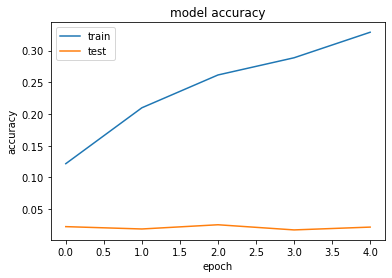

In [13]:
# Showing the course of the training
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

7/7 [==============================] - 7s 937ms/step - loss: 4.9959 - accuracy: 0.0215
Loss: 4.995945930480957 - Accuracy: 0.02146558091044426
7/7 [==============================] - 7s 944ms/step
[[0.00857986 0.03656904 0.00629892 ... 0.00316457 0.00704083 0.00344585]
 [0.01029778 0.02160086 0.00768397 ... 0.00325487 0.00467551 0.00272895]
 [0.01328077 0.01187992 0.0070105  ... 0.00273833 0.00292831 0.00172047]
 ...
 [0.00992838 0.02186226 0.00397309 ... 0.00474957 0.00776015 0.00395516]
 [0.00939479 0.02732804 0.01279094 ... 0.00508961 0.0051296  0.00474295]
 [0.01204925 0.0091059  0.00487099 ... 0.00531669 0.00387705 0.00196294]]
1351
[56 56 56 ... 56 56 77]


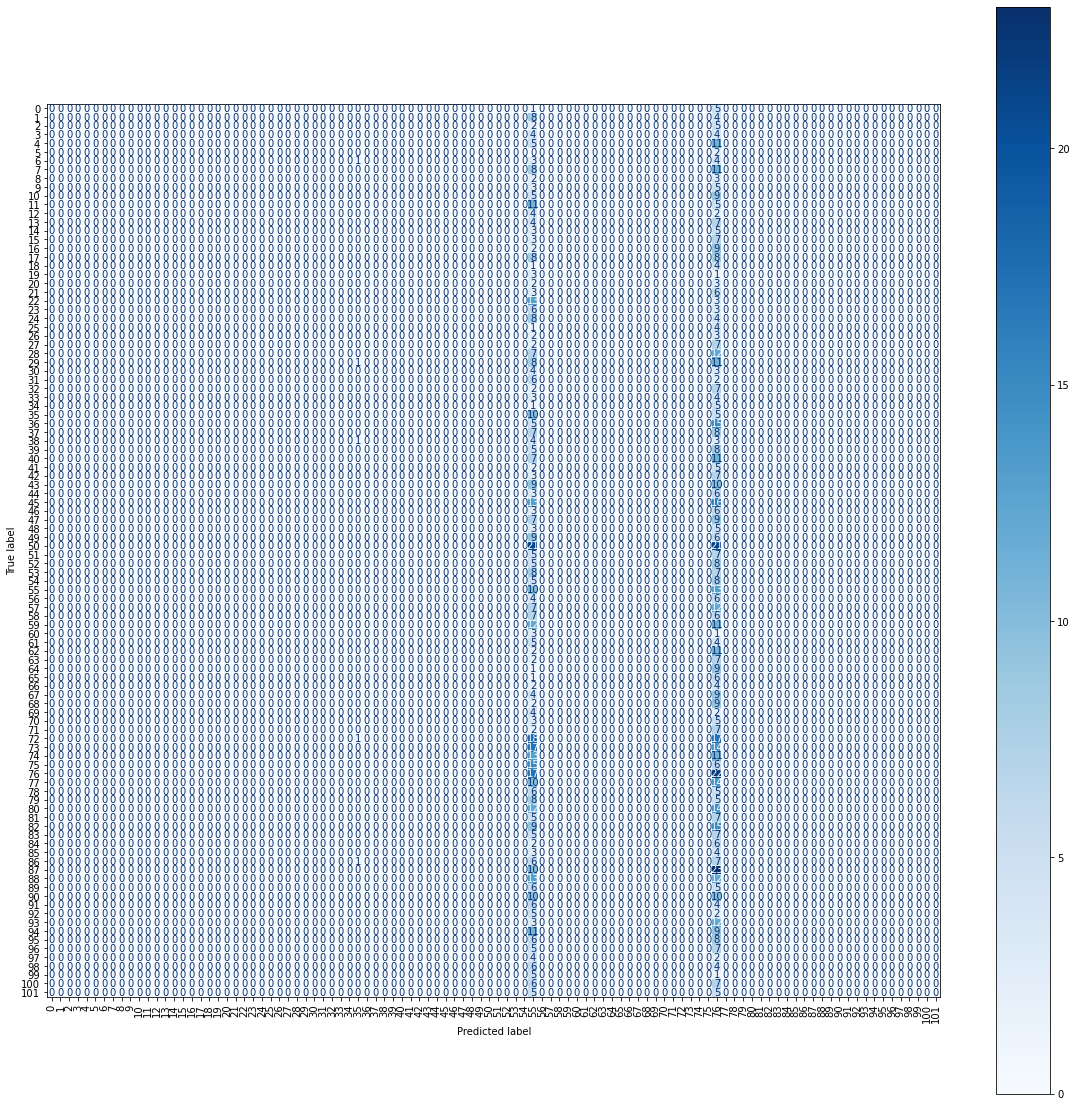

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Get Validate Values
LossAndAccuracy = model.evaluate(datagen_test)
print('Loss: {} - Accuracy: {}'.format(LossAndAccuracy[0], LossAndAccuracy[1]))

In [19]:
# Save Model
model.save('finalResult_Sascha.h5')